In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pyroomacoustics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 28.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.4-cp312-cp312-linux_x86_64.whl size=47010705 sha256=23f936640109d4ccba61e5fc1ca60b01481db83ea5177f490e165b89c24d88ad
  Stored in directory: /root/.cache/pip/wheels/71/2f/16/3cc6a78182189d4cde42c8f6658c1c8567cb4cc1146e61c9cb
Successfully built pyroomacoustics


In [ ]:
!pip install mir_eval

Starting the comprehensive project (Final Optimized Version)...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- Helper data (grid_points, delays) loaded successfully. ---

--- Phase 1: Starting Simulation ---
Performing manual simulation...


Simulation:  99%|█████████▉| 280/282 [00:21<00:00, 12.96it/s]



--- Phase 2: Starting Localization and Separation ---


Calculating Noise ReTM: 100%|██████████| 513/513 [00:00<00:00, 2476.62it/s]


✅ Undesired sources ReTM estimated successfully.


Localization:  99%|█████████▉| 218/220 [00:31<00:00,  6.97it/s]


✅ Trajectory estimated successfully for 218 frames.

--- Starting final separation with hybrid model ---


Separation (ReTM+GSC): 100%|██████████| 218/218 [00:02<00:00, 100.96it/s]


✅ Hybrid separation calculations completed successfully.

--- Reconstructing and presenting final output ---


🎉🎉🎉 Project completed successfully! 🎉🎉🎉
Final separated audio result:



✅ To download the file, click the three dots on the right of the audio player and select 'Download'.


--- Quantitative Evaluation and Visualization ---


/tmp/ipython-input-295822898.py:336: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr_after, sir_after, sar_after, _ = mir_eval.separation.bss_eval_sources(reference_sources, np.array([separated_est, mixture_in_eval_period - separated_est]))
/tmp/ipython-input-295822898.py:337: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr_retm, sir_retm, sar_retm, _ = mir_eval.separation.bss_eval_sources(reference_sources, np.array([intermediate_est_retm, mixture_in_eval_period - intermediate_est_retm]))
/tmp/ipython-input-295822898.py:339: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr_before, sir_before, sar_before, _ = mir_eval.separation.bss_eval_sources(reference_sources, np.array([mixture_in_eval_period, tiny_nois


Evaluation Results:
  - Before (Mixed):       SDR: -10.01 dB | SIR: 8.51 dB | SAR: -9.38 dB
  - Intermediate (ReTM):  SDR: -9.89 dB | SIR: 13.37 dB | SAR: -9.67 dB
  - Final (ReTM+GSC):     SDR: -2.68 dB | SIR: 19.40 dB | SAR: -2.61 dB

Plotting speaker trajectory...


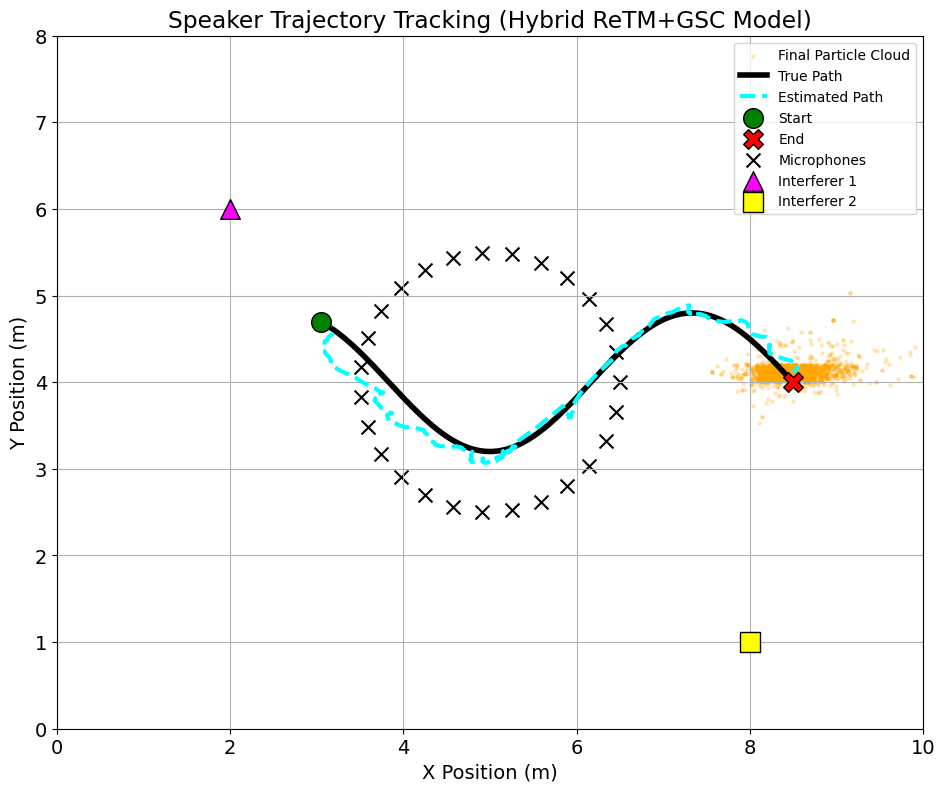


Plotting Spectrograms (4-Stage Comparison)...


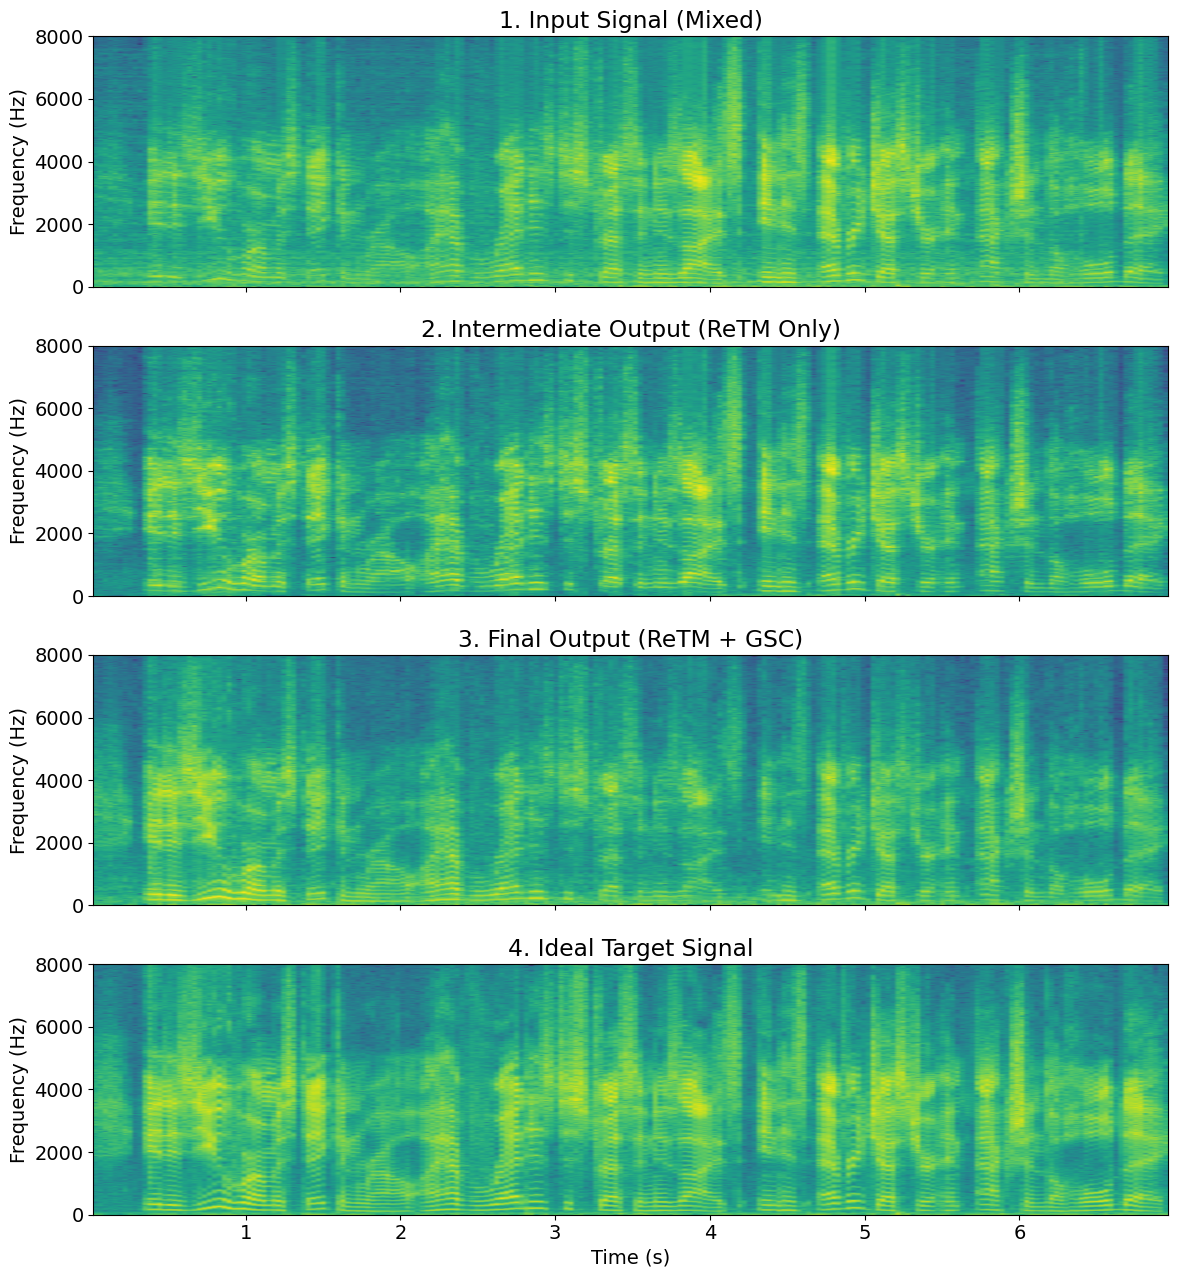


--- Comparative Visualization of Metrics (3-Stage) ---


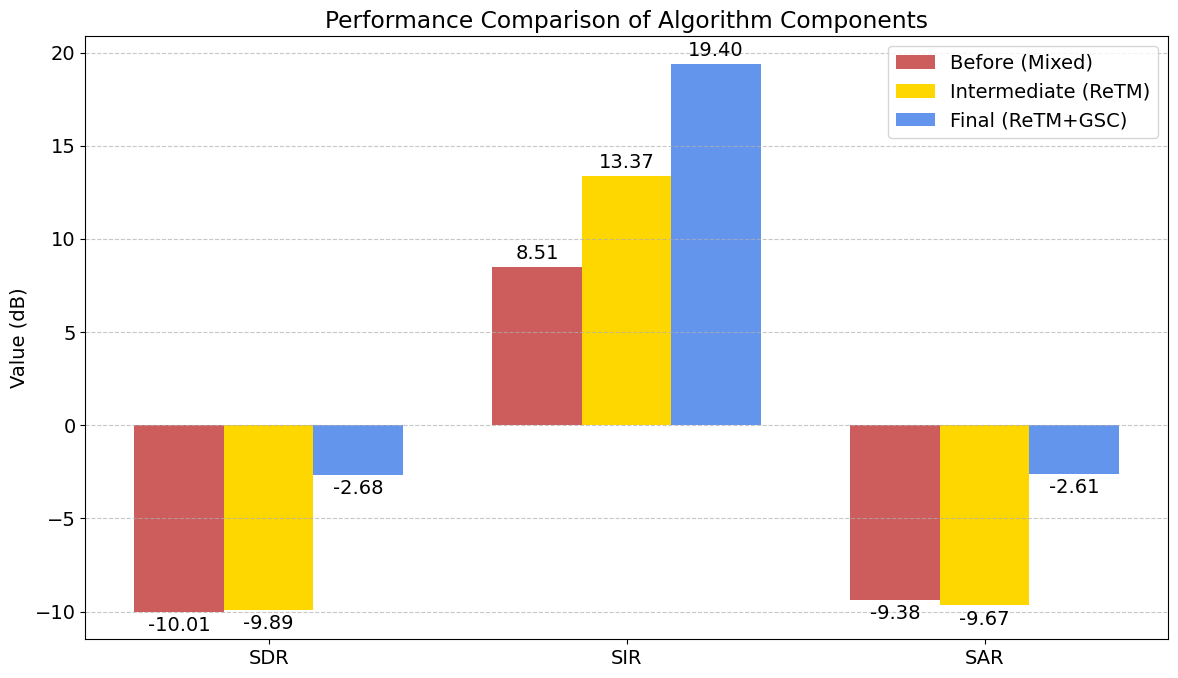


Plotting Final GSC Beampattern...


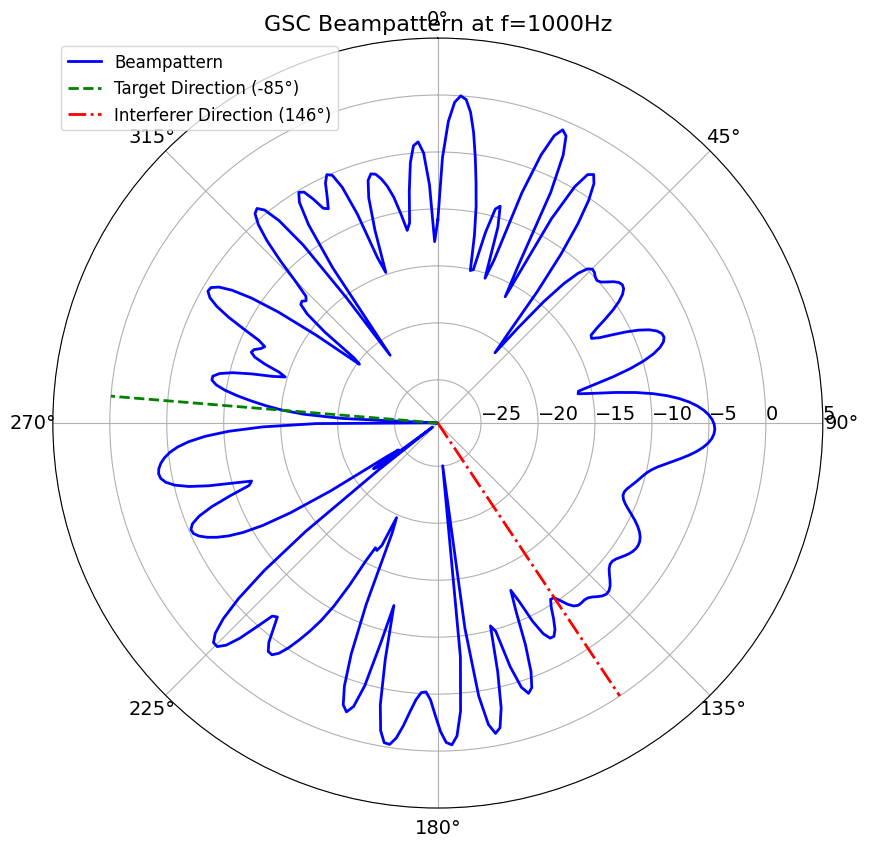

In [ ]:
import numpy as np
import pyroomacoustics as pra
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
import os
import librosa
from scipy.signal import stft, istft
from scipy.spatial.distance import cdist
from IPython.display import Audio, display
import mir_eval # کتابخانه برای سنجش عملکرد

# ==============================================================================
# بخش ۱: کلاس‌ها و توابع الگوریتم
# ==============================================================================
class ParticleFilter:
    def __init__(self, n_particles, grid_points, initial_pos=None, initial_spread=0.5):
        self.n_particles, self.grid_points = n_particles, grid_points
        if initial_pos is not None:
            self.particles = initial_pos.reshape(3, 1) + np.random.randn(3, n_particles) * initial_spread
        else:
            self.particles = grid_points[:, np.random.choice(grid_points.shape[1], n_particles)]
        self.weights = np.ones(n_particles) / n_particles
    def predict(self, process_noise=0.1):
        self.particles += np.random.randn(*self.particles.shape) * process_noise
    def update(self, srp_map):
        srp_map_non_negative = srp_map - np.min(srp_map)
        for i in range(self.n_particles):
            pos = self.particles[:, i]
            closest_grid_idx = np.argmin(np.sum((self.grid_points - pos[:, np.newaxis])**2, axis=0))
            self.weights[i] = srp_map_non_negative[closest_grid_idx]
        self.weights += 1e-9; self.weights /= np.sum(self.weights)
    def resample(self):
        indices = np.random.choice(self.n_particles, size=self.n_particles, p=self.weights)
        self.particles = self.particles[:, indices]; self.weights.fill(1.0 / self.n_particles)
    def estimate(self):
        return np.average(self.particles, weights=self.weights, axis=1)

class GSC_Beamformer:
    def __init__(self, mic_locs, fs, n_fft, hop, mu=0.1, c=343.0):
        self.mics = mic_locs
        self.n_mics = mic_locs.shape[1]
        self.fs = fs
        self.n_fft = n_fft
        self.hop = hop
        self.mu = mu
        self.c = c
        self.freq_bins = np.fft.rfftfreq(n_fft, d=1.0/fs)
        self.B = np.zeros((self.n_mics - 1, self.n_mics))
        for i in range(self.n_mics - 1):
            self.B[i, i] = 1
            self.B[i, i + 1] = -1
        self.adaptive_weights = np.zeros((self.n_mics - 1, len(self.freq_bins)), dtype=complex)

    def process_frame(self, stft_frame, target_pos):
        delays = np.sqrt(np.sum((self.mics.T - target_pos)**2, axis=1)) / self.c
        steering_vector = np.exp(-2j * np.pi * self.freq_bins * delays[:, np.newaxis])

        # =====>>> بهینه‌سازی: اعمال پنجره همینگ برای کاهش لبه‌های جانبی (Sidelobes) <<<=====
        window = np.hamming(self.n_mics)
        fbf_output = np.sum(np.conj(steering_vector) * window[:, np.newaxis] * stft_frame, axis=0) / np.sum(window)

        noise_reference = self.B @ stft_frame
        noise_estimate = np.sum(np.conj(self.adaptive_weights) * noise_reference, axis=0)
        output_signal = fbf_output - noise_estimate
        power = np.sum(np.abs(noise_reference)**2, axis=0) + 1e-9
        error_signal = output_signal

        leakage_factor = 1e-4
        self.adaptive_weights = (1 - leakage_factor) * self.adaptive_weights + self.mu * noise_reference * np.conj(error_signal) / power
        return output_signal

def precompute_delays(mic_locs, grid_points, fs, c=343.0):
    distances = cdist(grid_points.T, mic_locs.T); delays_sec = (distances - distances[:, 0][:, np.newaxis]) / c
    return np.round(delays_sec * fs).astype(int)

def calculate_gcc_phat_pairs(stft_frame, n_fft):
    cross_spectrum = np.conj(stft_frame[0, :]) * stft_frame; phat_cross_spectrum = cross_spectrum / (np.abs(cross_spectrum) + 1e-9)
    return np.fft.irfft(phat_cross_spectrum, n=n_fft, axis=1)

def build_srp_map(gcc_phat, delay_samples):
    n_points, n_mics = delay_samples.shape; srp_map = np.zeros(n_points)
    for k in range(n_points):
        power = 0;
        for i in range(n_mics): power += gcc_phat[i, delay_samples[k, i]]
        srp_map[k] = power
    return srp_map

def plot_beampattern(beamformer, target_pos, interferer_pos, mic_center, frequency=1000.0, c=343.0):
    """
    این تابع الگوی پرتوی یک بیم‌فورمر GSC را در یک فرکانس خاص رسم می‌کند.
    """
    mic_locs = beamformer.mics
    n_mics = beamformer.n_mics

    freq_idx = np.argmin(np.abs(beamformer.freq_bins - frequency))
    w_adaptive = beamformer.adaptive_weights[:, freq_idx]

    delays_target = np.sqrt(np.sum((mic_locs.T - target_pos)**2, axis=1)) / c
    steering_vector_target = np.exp(-2j * np.pi * frequency * delays_target)

    # اعمال پنجره همینگ در محاسبه وزن‌های بخش ثابت برای تطابق با بیم‌فورمر اصلی
    window = np.hamming(n_mics)
    w_fixed = (np.conj(steering_vector_target) * window) / np.sum(window)
    w_total = w_fixed - beamformer.B.T @ w_adaptive

    angles = np.linspace(0, 2 * np.pi, 360)
    gains = []
    for theta in angles:
        plane_wave_steering = np.exp(2j * np.pi * frequency / c * (mic_locs[0,:] * np.cos(theta) + mic_locs[1,:] * np.sin(theta)))
        gain = np.abs(np.conj(w_total) @ plane_wave_steering)
        gains.append(gain)

    gains = np.array(gains)
    gains_db = 20 * np.log10(gains / np.max(gains))
    gains_db = np.maximum(gains_db, -40)

    angle_target = np.arctan2(target_pos[1] - mic_center[1], target_pos[0] - mic_center[0])
    angle_interferer = np.arctan2(interferer_pos[1] - mic_center[1], interferer_pos[0] - mic_center[0])

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, gains_db, 'b-', linewidth=2, label='Beampattern')
    ax.plot([angle_target, angle_target], [np.min(gains_db), 0], 'g--', linewidth=2, label=f'Target Direction ({np.rad2deg(angle_target):.0f}°)')
    ax.plot([angle_interferer, angle_interferer], [np.min(gains_db), 0], 'r-.', linewidth=2, label=f'Interferer Direction ({np.rad2deg(angle_interferer):.0f}°)')

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.set_title(f'GSC Beampattern at f={frequency:.0f}Hz', fontsize=16)
    ax.set_ylim(np.min(gains_db), 5)
    ax.legend(fontsize=12)
    plt.show()

# ==============================================================================
# بخش ۲: اجرای کامل پروژه
# ==============================================================================
print("Starting the comprehensive project (Final Optimized Version)...")

# --- آماده‌سازی محیط ---
try:
    drive.mount('/content/drive'); DRIVE_PATH = '/content/drive/MyDrive/ReTM'
    os.makedirs(DRIVE_PATH, exist_ok=True)
except Exception: DRIVE_PATH = '.'

fs, room_dim, T60, n_fft, hop, n_mics = 16000, [10, 8, 3.5], 0.3, 1024, 512, 27
mic_center = np.array([room_dim[0]/2, room_dim[1]/2, 1.2])
mic_radius = 1.5
mic_locs = pra.circular_2D_array(center=mic_center[:2], M=n_mics, phi0=0, radius=mic_radius)
mic_locs = np.concatenate((mic_locs, np.ones((1, n_mics)) * mic_center[2]), axis=0)
e_absorption, max_order = pra.inverse_sabine(T60, room_dim)

# --- بارگذاری اطلاعات کمکی برای مکان‌یابی ---
dictionary_file = os.path.join(DRIVE_PATH, 'rtf_dictionary_complete.npz')
try:
    dictionary_data = np.load(dictionary_file)
    grid_points = dictionary_data['grid_points']; delay_samples = dictionary_data['delays']
    print("\n--- Helper data (grid_points, delays) loaded successfully. ---")
except (FileNotFoundError, KeyError):
    print("Error: Helper file for localization not found.")
    exit()

# ==============================================================================
# بخش ۳: شبیه‌سازی محیط
# ==============================================================================
print("\n--- Phase 1: Starting Simulation ---")
simulation_duration = 9.0; n_samples = int(simulation_duration * fs); n_frames_calc = int(np.ceil(simulation_duration * fs / hop))

stationary_sources = {
    'interferer1': {'pos': [2, 6, 1.6], 'file': os.path.join(DRIVE_PATH, 'interferer1.wav'), 'scale': 0.8},
    'noise1': {'pos': [8, 1, 1.0], 'file': os.path.join(DRIVE_PATH, 'noise1.wav'), 'scale': 0.6}
}

try:
    target_audio_original, sr = sf.read(os.path.join(DRIVE_PATH, 'clean_target_speech.wav'))
    if sr != fs: target_audio_original = librosa.resample(target_audio_original, orig_sr=sr, target_sr=fs)

    silence_duration = 2.0
    silence_samples = int(silence_duration * fs)
    silence_part = np.zeros(silence_samples)
    target_audio_with_silence = np.concatenate((silence_part, target_audio_original))

    target_audio_sim = np.zeros(n_samples)
    len_to_copy = min(len(target_audio_with_silence), n_samples)
    target_audio_sim[:len_to_copy] = target_audio_with_silence[:len_to_copy]

    interference_signal = np.zeros(n_samples)
    for name, source_info in stationary_sources.items():
        audio, sr = sf.read(source_info['file']);
        if sr != fs: audio = librosa.resample(audio, orig_sr=sr, target_sr=fs)
        if len(audio) > n_samples: audio = audio[:n_samples]
        else: audio = np.pad(audio, (0, n_samples - len(audio)))
        source_info['signal'] = audio
        interference_signal += audio * source_info['scale']

except Exception as e:
    print(f"Error loading audio files: {e}")

start_point = np.array([1.5, 4.0, 1.6]); end_point = np.array([8.5, 4.0, 1.6]); t = np.linspace(0, 1, n_frames_calc)
main_path_x = start_point[0] + t * (end_point[0] - start_point[0]); main_path_y = start_point[1] + t * (end_point[1] - start_point[1])
deviation = 0.8 * np.sin(t * 3 * np.pi)
true_trajectory_frames = np.array([main_path_x, main_path_y + deviation, np.ones(n_frames_calc) * 1.6])

print("Performing manual simulation...")
mixed_mic_signals = np.zeros((n_mics, n_samples))
for i in tqdm(range(n_frames_calc), desc="Simulation"):
    start, end = i * hop, i * hop + n_fft
    if end > n_samples: break
    room_sim = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=3)
    room_sim.add_microphone_array(mic_locs)
    room_sim.add_source(true_trajectory_frames[:, i], signal=target_audio_sim[start:end])
    for name, source_info in stationary_sources.items():
        room_sim.add_source(source_info['pos'], signal=source_info['signal'][start:end] * source_info['scale'])
    room_sim.simulate()
    mixed_mic_signals[:, start:end] += room_sim.mic_array.signals[:, :n_fft]

# ==============================================================================
# بخش ۴: اجرای مکان‌یابی و جداسازی
# ==============================================================================
print("\n--- Phase 2: Starting Localization and Separation ---")

# --- ۱. تخمین مدل نویز ---
undesired_chunk = mixed_mic_signals[:, :silence_samples]
_, _, undesired_stft = stft(undesired_chunk, fs=fs, nperseg=n_fft, noverlap=hop)
Q_A = 10; mic_group_A_indices = list(range(Q_A)); mic_group_B_indices = list(range(Q_A, n_mics))
M_A_undesired = undesired_stft[mic_group_A_indices, :, :]; M_B_undesired = undesired_stft[mic_group_B_indices, :, :]
n_freq_bins = M_A_undesired.shape[1]
ReTM_undesired = np.zeros((Q_A, len(mic_group_B_indices), n_freq_bins), dtype=complex)

for f_idx in tqdm(range(n_freq_bins), desc="Calculating Noise ReTM"):
    ReTM_undesired[:, :, f_idx] = M_A_undesired[:, f_idx, :] @ np.linalg.pinv(M_B_undesired[:, f_idx, :])

print("✅ Undesired sources ReTM estimated successfully.")


# --- ۲. ردیابی مسیر هدف ---
silence_frames = int(silence_duration * fs / hop)
initial_pos = true_trajectory_frames[:, silence_frames]
particle_filter = ParticleFilter(n_particles=2000, grid_points=grid_points, initial_pos=initial_pos)
estimated_trajectory_pf = []
energy_threshold = 1e-5

for i in tqdm(range(silence_frames, n_frames_calc), desc="Localization"):
    start, end = i * hop, i * hop + n_fft
    if end > mixed_mic_signals.shape[1]: break
    chunk = mixed_mic_signals[:, start:end]

    if np.mean(chunk**2) > energy_threshold:
        particle_filter.predict(process_noise=0.1)
        _, _, chunk_stft = stft(chunk, fs=fs, nperseg=n_fft, noverlap=None)
        stft_frame = chunk_stft[:, :, 0]
        gcc_phat_pairs = calculate_gcc_phat_pairs(stft_frame, n_fft)
        srp_power_map = build_srp_map(gcc_phat_pairs, delay_samples)
        particle_filter.update(srp_power_map)
        particle_filter.resample()

    estimated_pos = particle_filter.estimate()
    estimated_trajectory_pf.append(estimated_pos)

estimated_trajectory_pf = np.array(estimated_trajectory_pf).T
print(f"✅ Trajectory estimated successfully for {estimated_trajectory_pf.shape[1]} frames.")

# --- ۳. حلقه جداسازی نهایی ---
print("\n--- Starting final separation with hybrid model ---")

_, _, mixed_stft_full = stft(mixed_mic_signals, fs=fs, nperseg=n_fft, noverlap=hop)
M_A_mixed = mixed_stft_full[mic_group_A_indices, :, :]
M_B_mixed = mixed_stft_full[mic_group_B_indices, :, :]
n_total_stft_frames = mixed_stft_full.shape[2]

gsc_beamformer = GSC_Beamformer(mic_locs, fs, n_fft, hop, mu=0.001)

intermediate_stft_retm_only = np.zeros_like(mixed_stft_full)
separated_signal_stft = np.zeros((1, n_freq_bins, n_total_stft_frames), dtype=complex)
num_estimated_frames = estimated_trajectory_pf.shape[1]
loop_start_frame = silence_frames

for idx, frame_num in enumerate(tqdm(range(loop_start_frame, loop_start_frame + num_estimated_frames), desc="Separation (ReTM+GSC)")):
    noise_estimate_at_A = np.einsum('abf,bf->af', ReTM_undesired, M_B_mixed[:, :, frame_num])
    separated_frame_group_A = M_A_mixed[:, :, frame_num] - noise_estimate_at_A

    pre_cleaned_stft_frame = mixed_stft_full[:, :, frame_num].copy()
    pre_cleaned_stft_frame[mic_group_A_indices, :] = separated_frame_group_A
    intermediate_stft_retm_only[:, :, frame_num] = pre_cleaned_stft_frame

    estimated_pos = estimated_trajectory_pf[:, idx]
    output_frame = gsc_beamformer.process_frame(pre_cleaned_stft_frame, estimated_pos)
    separated_signal_stft[0, :, frame_num] = output_frame

print("✅ Hybrid separation calculations completed successfully.")

# ==============================================================================
# بخش ۵: بازسازی و ارائه خروجی
# ==============================================================================
print("\n--- Reconstructing and presenting final output ---")
_, separated_audio = istft(separated_signal_stft, fs=fs, nperseg=n_fft, noverlap=hop)
separated_audio = separated_audio.squeeze()

_, intermediate_audio_retm_only_full = istft(intermediate_stft_retm_only, fs=fs, nperseg=n_fft, noverlap=hop)
intermediate_audio_retm_only = intermediate_audio_retm_only_full[0, :].squeeze()

max_val = np.max(np.abs(separated_audio))
if max_val > 0: audio_for_playback = separated_audio / max_val
else: audio_for_playback = separated_audio

print("\n\n======================================================")
print(f"🎉🎉🎉 Project completed successfully! 🎉🎉🎉")
print("======================================================")
print("Final separated audio result:")
display(Audio(audio_for_playback, rate=fs))
print("\n✅ To download the file, click the three dots on the right of the audio player and select 'Download'.")


# ==============================================================================
# بخش ۶: سنجش کمی و مصورسازی نتایج
# ==============================================================================
print("\n\n--- Quantitative Evaluation and Visualization ---")
try:
    effective_len = len(separated_audio) - silence_samples
    if effective_len <= 0: raise ValueError("Separated signal is not long enough for evaluation.")

    target_ref = target_audio_original[:effective_len]
    interference_ref = interference_signal[silence_samples : silence_samples + effective_len]

    separated_est = separated_audio[silence_samples : silence_samples + effective_len]
    intermediate_est_retm = intermediate_audio_retm_only[silence_samples : silence_samples + effective_len]
    mixture_in_eval_period = mixed_mic_signals[0, silence_samples : silence_samples + effective_len]

    min_len = min(len(target_ref), len(separated_est), len(intermediate_est_retm), len(mixture_in_eval_period))
    target_ref, interference_ref = target_ref[:min_len], interference_ref[:min_len]
    separated_est, intermediate_est_retm, mixture_in_eval_period = separated_est[:min_len], intermediate_est_retm[:min_len], mixture_in_eval_period[:min_len]

    reference_sources = np.array([target_ref, interference_ref])

    sdr_after, sir_after, sar_after, _ = mir_eval.separation.bss_eval_sources(reference_sources, np.array([separated_est, mixture_in_eval_period - separated_est]))
    sdr_retm, sir_retm, sar_retm, _ = mir_eval.separation.bss_eval_sources(reference_sources, np.array([intermediate_est_retm, mixture_in_eval_period - intermediate_est_retm]))
    tiny_noise = np.random.randn(len(mixture_in_eval_period)) * 1e-9
    sdr_before, sir_before, sar_before, _ = mir_eval.separation.bss_eval_sources(reference_sources, np.array([mixture_in_eval_period, tiny_noise]))

    print("\nEvaluation Results:")
    print(f"  - Before (Mixed):       SDR: {sdr_before[0]:.2f} dB | SIR: {sir_before[0]:.2f} dB | SAR: {sar_before[0]:.2f} dB")
    print(f"  - Intermediate (ReTM):  SDR: {sdr_retm[0]:.2f} dB | SIR: {sir_retm[0]:.2f} dB | SAR: {sar_retm[0]:.2f} dB")
    print(f"  - Final (ReTM+GSC):     SDR: {sdr_after[0]:.2f} dB | SIR: {sir_after[0]:.2f} dB | SAR: {sar_after[0]:.2f} dB")

except Exception as e:
    print(f"\n❌ An error occurred during performance evaluation: {e}")

print("\nPlotting speaker trajectory...")
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 9)})
fig, ax = plt.subplots()
final_particles = particle_filter.particles
ax.scatter(final_particles[0, :], final_particles[1, :], color='orange', s=5, alpha=0.2, label='Final Particle Cloud')
ax.plot(true_trajectory_frames[0, silence_frames:], true_trajectory_frames[1, silence_frames:], color='black', linestyle='-', linewidth=4, label='True Path')
ax.plot(estimated_trajectory_pf[0, :], estimated_trajectory_pf[1, :], color='cyan', linestyle='--', linewidth=3, label='Estimated Path')
ax.scatter(true_trajectory_frames[0, silence_frames], true_trajectory_frames[1, silence_frames], c='green', s=200, marker='o', edgecolors='black', label='Start', zorder=5)
ax.scatter(true_trajectory_frames[0, -1], true_trajectory_frames[1, -1], c='red', s=200, marker='X', edgecolors='black', label='End', zorder=5)
ax.scatter(mic_locs[0, :], mic_locs[1, :], c='black', marker='x', s=100, label='Microphones')
ax.scatter( stationary_sources['interferer1']['pos'][0], stationary_sources['interferer1']['pos'][1], c='magenta', marker='^', s=200, edgecolors='black', label='Interferer 1', zorder=5)
ax.scatter(stationary_sources['noise1']['pos'][0], stationary_sources['noise1']['pos'][1], c='yellow', marker='s', s=200, edgecolors='black', label='Interferer 2', zorder=5)
ax.set_title('Speaker Trajectory Tracking (Hybrid ReTM+GSC Model)')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.legend(fontsize=10)
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([0, room_dim[0]])
ax.set_ylim([0, room_dim[1]])
plt.show()

# ==============================================================================
# بخش ۷: مصورسازی مقایسه‌ای
# ==============================================================================
print("\nPlotting Spectrograms (4-Stage Comparison)...")
fig, axs = plt.subplots(4, 1, figsize=(12, 13), sharex=True, sharey=True)
common_params = {'NFFT': n_fft, 'Fs': fs, 'noverlap': hop, 'cmap': 'viridis'}

axs[0].specgram(mixture_in_eval_period, **common_params)
axs[0].set_title('1. Input Signal (Mixed)')
axs[0].set_ylabel('Frequency (Hz)')

axs[1].specgram(intermediate_est_retm, **common_params)
axs[1].set_title('2. Intermediate Output (ReTM Only)')
axs[1].set_ylabel('Frequency (Hz)')

axs[2].specgram(separated_est, **common_params)
axs[2].set_title('3. Final Output (ReTM + GSC)')
axs[2].set_ylabel('Frequency (Hz)')

axs[3].specgram(target_ref, **common_params)
axs[3].set_title('4. Ideal Target Signal')
axs[3].set_xlabel('Time (s)')
axs[3].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

print("\n--- Comparative Visualization of Metrics (3-Stage) ---")
metrics_labels = ['SDR', 'SIR', 'SAR']
before_values = [sdr_before[0], sir_before[0], sar_before[0]]
retm_values = [sdr_retm[0], sir_retm[0], sar_retm[0]]
after_values = [sdr_after[0], sir_after[0], sar_after[0]]

x = np.arange(len(metrics_labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width, before_values, width, label='Before (Mixed)', color='indianred')
rects2 = ax.bar(x, retm_values, width, label='Intermediate (ReTM)', color='gold')
rects3 = ax.bar(x + width, after_values, width, label='Final (ReTM+GSC)', color='cornflowerblue')

ax.set_ylabel('Value (dB)')
ax.set_title('Performance Comparison of Algorithm Components')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')
fig.tight_layout()
plt.show()

# ==============================================================================
# بخش ۸: مصورسازی عملکرد بیم‌فورمر
# ==============================================================================
print("\nPlotting Final GSC Beampattern...")

analysis_frame_index = len(estimated_trajectory_pf[0]) // 2
target_position_at_t = estimated_trajectory_pf[:, analysis_frame_index]
interferer_position = stationary_sources['interferer1']['pos']

plot_beampattern(
    beamformer=gsc_beamformer,
    target_pos=target_position_at_t,
    interferer_pos=interferer_position,
    mic_center=mic_center,
    frequency=1000.0
)